# Actividad 4 - Programación Lineal

### 1. Importar librerías y cargar datos

In [1]:
# Importar las librerías necesarias
import pandas as pd
import pulp
import matplotlib.pyplot as plt

In [2]:
# Cargar los datos del archivo CSV
datos = pd.read_csv("actividad_semana_4.csv")

print(f"Datos cargados exitosamente {datos.shape}")

# Mostrar las primeras filas
print("\nPrimeras filas de los datos:")
datos.head()

Datos cargados exitosamente (20, 4)

Primeras filas de los datos:


,id,rol,salario,score
0,1,Backend,80000,75
1,2,Backend,87000,78
2,3,Backend,82000,70
3,4,Backend,90000,80
4,5,Backend,86000,77


## 2. Análisis de los datos

Voy a explorar los datos para entender las características de cada área.

In [3]:
# Ver información general de los datos
print("INFORMACION BASICA DE LOS DATOS")
print("Total de empleados:", len(datos))
print("Columnas disponibles:", list(datos.columns))

# Ver la distribución por rol
print("\nDistribución por rol:")
print(datos['rol'].value_counts())

INFORMACION BASICA DE LOS DATOS
Total de empleados: 20
Columnas disponibles: ['id', 'rol', 'salario', 'score']

Distribución por rol:
rol
Backend    10
Data       10
Name: count, dtype: int64


In [4]:
# Calcular estadísticas por área
estadisticas_por_area = datos.groupby('rol').agg({
    'salario': ['mean', 'min', 'max'],
    'score': ['mean', 'min', 'max']
})

print("ESTADISTICAS POR AREA:")
print(estadisticas_por_area)

# Calculamos los promedios que vamos a usar en el modelo
salario_backend = datos[datos['rol'] == 'Backend']['salario'].mean()
salario_data = datos[datos['rol'] == 'Data']['salario'].mean()
score_backend = datos[datos['rol'] == 'Backend']['score'].mean()
score_data = datos[datos['rol'] == 'Data']['score'].mean()

print("\nPROMEDIOS PARA EL MODELO:")
print(f"Salario promedio Backend: ${salario_backend:.2f}")
print(f"Salario promedio Data: ${salario_data:.2f}")
print(f"Score promedio Backend: {score_backend:.2f}")
print(f"Score promedio Data: {score_data:.2f}")

ESTADISTICAS POR AREA:
         salario               score        
            mean    min    max  mean min max
rol                                         
Backend  84900.0  80000  90000  76.2  70  81
Data     78500.0  75000  82000  72.0  69  75

PROMEDIOS PARA EL MODELO:
Salario promedio Backend: $84900.00
Salario promedio Data: $78500.00
Score promedio Backend: 76.20
Score promedio Data: 72.00


## 3. Formulación del problema de programación lineal

Ahora voy a formular el problema matemáticamente:

**Variables de decisión:**
- x1 = cantidad de empleados Backend a contratar
- x2 = cantidad de empleados Data a contratar

**Función objetivo (minimizar):**
- Z = salario_backend * x1 + salario_data * x2

**Restricciones:**
- x1 + x2 >= 10 (al menos 10 empleados total)
- x1 >= 3 (al menos 3 Backend)
- x2 >= 3 (al menos 3 Data)
- score_backend * x1 + score_data * x2 >= 600 (suma de scores al menos 600)

In [6]:
# Crear el problema de programación lineal
problema = pulp.LpProblem("Contratacion_Empleados", pulp.LpMinimize)

# Definir las variables de decisión
x1 = pulp.LpVariable("Backend", lowBound=0, cat='Integer')  # Cantidad de empleados Backend
x2 = pulp.LpVariable("Data", lowBound=0, cat='Integer')     # Cantidad de empleados Data

# Función objetivo: minimizar la nómina total
problema += salario_backend * x1 + salario_data * x2, "Nomina_Total"

# Agregar las restricciones
problema += x1 + x2 >= 10, "Minimo_empleados_total"
problema += x1 >= 3, "Minimo_Backend"
problema += x2 >= 3, "Minimo_Data"
problema += score_backend * x1 + score_data * x2 >= 600, "Minimo_score_total"

print("Problema formulado correctamente")
print("\nResumen del problema:")
print(f"Minimizar: {salario_backend:.2f} * Backend + {salario_data:.2f} * Data")
print("Sujeto a:")
print("- Backend + Data >= 10")
print("- Backend >= 3")
print("- Data >= 3")
print(f"- {score_backend:.2f} * Backend + {score_data:.2f} * Data >= 600")
print('\nProblema:\n', problema)

Problema formulado correctamente

Resumen del problema:
Minimizar: 84900.00 * Backend + 78500.00 * Data
Sujeto a:
- Backend + Data >= 10
- Backend >= 3
- Data >= 3
- 76.20 * Backend + 72.00 * Data >= 600

Problema:
 Contratacion_Empleados:
MINIMIZE
84900.0*Backend + 78500.0*Data + 0.0
SUBJECT TO
Minimo_empleados_total: Backend + Data >= 10

Minimo_Backend: Backend >= 3

Minimo_Data: Data >= 3

Minimo_score_total: 76.2 Backend + 72 Data >= 600

VARIABLES
0 <= Backend Integer
0 <= Data Integer



## 4. Resolver el problema

Ahora resuelvo el problema usando PuLP.

In [7]:
# Resolver el problema
solver = pulp.PULP_CBC_CMD(msg=0)  # msg=0 para no mostrar información técnica
problema.solve(solver)

# Verificar si se encontró una solución
print("Estado de la solución:", pulp.LpStatus[problema.status])

if problema.status == 1:  # Si se encontró solución óptima
    print("\nSOLUCION OPTIMA ENCONTRADA:")
    print(f"Empleados Backend a contratar: {int(x1.varValue)}")
    print(f"Empleados Data a contratar: {int(x2.varValue)}")
    print(f"Total de empleados: {int(x1.varValue + x2.varValue)}")
    print(f"Nómina total mínima: ${pulp.value(problema.objective):,.2f}")
    
    # Verificar que se cumplen las restricciones
    total_empleados = x1.varValue + x2.varValue
    total_score = score_backend * x1.varValue + score_data * x2.varValue
    
    print("\nVERIFICACION DE RESTRICCIONES:")
    print(f"Total empleados: {total_empleados} >= 10: {total_empleados >= 10}")
    print(f"Backend: {x1.varValue} >= 3: {x1.varValue >= 3}")
    print(f"Data: {x2.varValue} >= 3: {x2.varValue >= 3}")
    print(f"Score total: {total_score:.2f} >= 600: {total_score >= 600}")
else:
    print("No se pudo encontrar una solución válida")

Estado de la solución: Optimal

SOLUCION OPTIMA ENCONTRADA:
Empleados Backend a contratar: 3
Empleados Data a contratar: 7
Total de empleados: 10
Nómina total mínima: $804,200.00

VERIFICACION DE RESTRICCIONES:
Total empleados: 10.0 >= 10: True
Backend: 3.0 >= 3: True
Data: 7.0 >= 3: True
Score total: 732.60 >= 600: True


## 5. Visualización de resultados

Voy a crear algunos gráficos para mostrar los resultados.

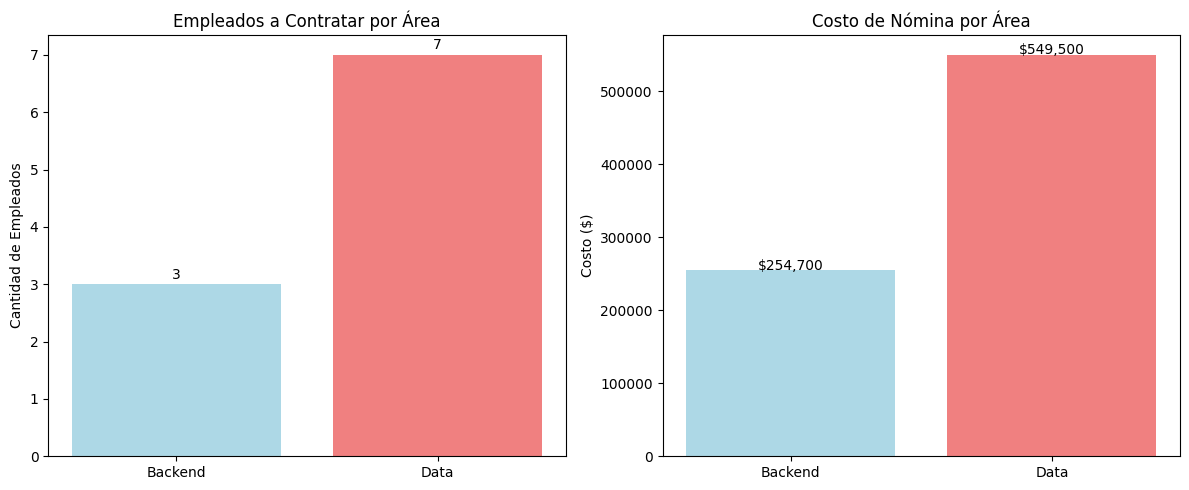

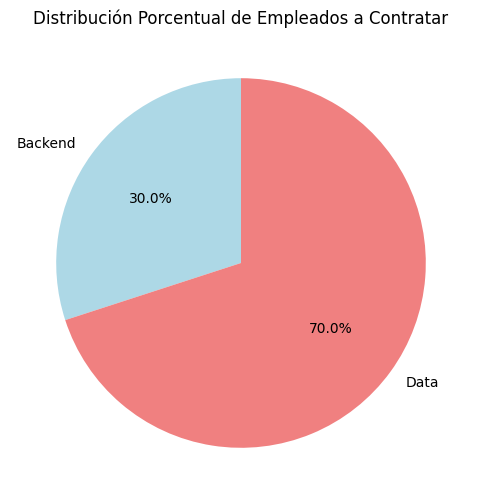

In [8]:
# Crear gráficos de la solución
if problema.status == 1:
    # Calcular costos para los gráficos
    costo_backend_total = salario_backend * x1.varValue
    costo_data_total = salario_data * x2.varValue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico 1: Distribución de empleados
    areas = ['Backend', 'Data']
    empleados = [x1.varValue, x2.varValue]
    colores = ['lightblue', 'lightcoral']
    
    ax1.bar(areas, empleados, color=colores)
    ax1.set_title('Empleados a Contratar por Área')
    ax1.set_ylabel('Cantidad de Empleados')
    for i, v in enumerate(empleados):
        ax1.text(i, v + 0.1, str(int(v)), ha='center')
    
    # Gráfico 2: Distribución de costos
    costos = [costo_backend_total, costo_data_total]
    
    ax2.bar(areas, costos, color=colores)
    ax2.set_title('Costo de Nómina por Área')
    ax2.set_ylabel('Costo ($)')
    for i, v in enumerate(costos):
        ax2.text(i, v + 1000, f'${v:,.0f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico circular de distribución de empleados
    plt.figure(figsize=(8, 6))
    plt.pie(empleados, labels=areas, colors=colores, autopct='%1.1f%%', startangle=90)
    plt.title('Distribución Porcentual de Empleados a Contratar')
    plt.show()

## 6. Conclusiones

Basándome en los resultados obtenidos, puedo concluir lo siguiente:

In [ ]:
# Resumen final de conclusiones
if problema.status == 1:
    print("CONCLUSIONES DEL ANALISIS:")
    print("=" * 50)
    
    print("\n1. SOLUCION OPTIMA:")
    print(f"   - Contratar {int(x1.varValue)} empleados Backend")
    print(f"   - Contratar {int(x2.varValue)} empleados Data")
    print(f"   - Nómina total mínima: ${pulp.value(problema.objective):,.2f}")
    
    print("\n2. CUMPLIMIENTO DE RESTRICCIONES:")
    print(f"   - Total empleados: {int(total_empleados)} (mínimo requerido: 10)")
    print(f"   - Score total: {total_score:.1f} (mínimo requerido: 600)")
    
    print("\n3. ANALISIS ECONOMICO:")
    costo_promedio = pulp.value(problema.objective) / total_empleados
    print(f"   - Costo promedio por empleado: ${costo_promedio:,.2f}")
    
    if salario_backend < salario_data:
        print(f"   - Los empleados Backend son más económicos (${salario_backend:.2f} vs ${salario_data:.2f})")
    else:
        print(f"   - Los empleados Data son más económicos (${salario_data:.2f} vs ${salario_backend:.2f})")

    print("\n4. RECOMENDACION:")
    print("   La empresa debe seguir esta estrategia de contratación para")
    print("   minimizar costos mientras cumple con todos los requisitos.")
else:
    print("No se pudo resolver el problema. Revisar las restricciones.")

CONCLUSIONES DEL ANALISIS:

1. SOLUCION OPTIMA:
   - Contratar 3 empleados Backend
   - Contratar 7 empleados Data
   - Nómina total mínima: $804,200.00

2. CUMPLIMIENTO DE RESTRICCIONES:
   - Total empleados: 10 (mínimo requerido: 10)
   - Score total: 732.6 (mínimo requerido: 600)

3. ANALISIS ECONOMICO:
   - Costo promedio por empleado: $80,420.00
   - Los empleados Data son más económicos ($78500.00 vs $84900.00)

4. RECOMENDACION:
   La empresa debe seguir esta estrategia de contratación para
   minimizar costos mientras cumple con todos los requisitos.
